In [1]:
# this leaky bucket method is described by
# Hogg, E.H., Barr, A.G., Black, T.A., 2013. "A simple soil moisture index
# for representing multi-year drought impacts on aspen productivity in the
# western Canadian interior." Agricultural and Forest Meteorology (178–179): 173–182.
# https://doi.org/10.1016/j.agrformet.2013.04.025

# it is adapted here to include an SMI_MIN parameter, which imposes a minimum
# soil moisture index

In [2]:
# import multiprocessing
# multiprocessing.set_start_method('spawn')

In [3]:
import glob
import os
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.lax import scan
from jax import vmap, grad
from datetime import datetime, timedelta
from jax import jacfwd, jacrev, jit
from pyarrow import csv as pv

from functools import partial
from scipy.optimize import minimize

from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

import matplotlib.pyplot as plt

In [4]:
import jax
jax.config.update("jax_platform_name", "cpu")

In [5]:
DATA_DIR = "../../data"

In [6]:
PLOTS = os.path.join(DATA_DIR, "interim", "plot_info_for_climatena.csv")
plots = (
    pd.read_csv(PLOTS, dtype={"PLOT_ID": int})
    .rename({"ID1": "PLOT_ID"}, axis=1)
    .drop(["ID2"], axis=1)
    .set_index("PLOT_ID")
)
plots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     12156 non-null  float64
 1   lon     12156 non-null  float64
 2   el      12156 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 379.9 KB


# Adapt this workflow to hold out days where SMAP is not available from scoring, but not from prediction

In [8]:
def hessian(fun):
    return jit(jacfwd(jacrev(fun)))


def leaky_bucket(smi, weather, smi_min, smi_crit, smi_max):
    precip, pot_evap = weather
    k_m = 2 * (smi / smi_crit) - (smi / smi_crit) ** 2
    evap = pot_evap * k_m
    smi = jnp.clip(smi + precip - evap, smi_min, smi_max)
    return smi, smi


def scan_leaky(weather, smi_min, smi_crit, smi_max):
    partial_leaky = partial(
        leaky_bucket, smi_min=smi_min, smi_crit=smi_crit, smi_max=smi_max
    )
    _, smi = scan(partial_leaky, init=smi_max, xs=weather)
    return smi


def fit_3param(idx, method="SLSQP", get_result=False, get_data=False, get_params=True):
    obs = pd.read_parquet(
        os.path.join(DATA_DIR, "interim", "leaky_bucket", f"{idx}.parquet"),
        columns=["PLOT_ID", "DATE", "SM_MM", "PPT", "EREF_HARGREAVES"], 
    )
    # obs = pd.read_csv(
    #     os.path.join(DATA_DIR, "interim", "leaky_bucket", f"{idx}.csv"),
    #     usecols=["PLOT_ID", "DATE", "SM_MM", "PPT", "EREF_HARGREAVES"], 
    # )
    
    obs["DATE"] =  pd.to_datetime(obs.DATE).dt.to_period("D")
    obs.set_index(["PLOT_ID", "DATE"], inplace=True)
    y_obs = obs.loc[idx, "SM_MM"].dropna()
    
    if len(y_obs) == 0:
        return {"PLOT_ID": idx}
    
    smi_min = np.array(y_obs.min()).reshape(-1)
    smi_max = np.array(y_obs.max()).reshape(-1)
    rng = smi_max - smi_min
    evap = obs.loc[idx, "EREF_HARGREAVES"]
    precip = obs.loc[idx, "PPT"]
    X = (precip.values, evap.values)
    mask = evap.index.isin(y_obs.index)
    
    def get_sse(smi_crit):
        smi = scan_leaky(X, smi_min, smi_crit, smi_max)
        y_pred = smi[mask]
        return ((y_pred - (y_obs.values)) ** 2).sum()

    JAC_METH = [
        "CG",
        "BFGS",
        "Newton-CG",
        "L-BFGS-B",
        "TNC",
        "SLSQP",
        "dogleg",
        "trust-ncg",
        "trust-krylov",
        "trust-exact",
        "trust-constr",
    ]
    jac = jit(grad(get_sse)) if method in JAC_METH else None
    HESS_METH = [
        "Newton-CG",
        "dogleg",
        "trust-ncg",
        "trust-krylov",
        "trust-exact",
        "trust-constr",
    ]
    hess = hessian(get_sse) if method in HESS_METH else None

    res = minimize(
        get_sse,
        x0=(smi_min + 0.85 * rng),
        method=method,
        jac=jac,
        hess=hess,
        bounds=((smi_min + 0.65 * rng, smi_min + 0.95 * rng),),
    )
    to_return = {"PLOT_ID": idx}
    if get_result:
        to_return['RESULT'] = res
    if get_data:
        to_return["DATE"] = y_obs.index
        to_return["OBS"] = y_obs.values
        to_return["PRED"] = scan_leaky(X, smi_min, res.x, smi_max)[mask]
    if get_params:
        to_return["SMI_MIN"] = int(smi_min[0])
        to_return["SMI_CRIT"] = int(res.x[0])
        to_return["SMI_MAX"] = int(smi_max[0])
    return to_return

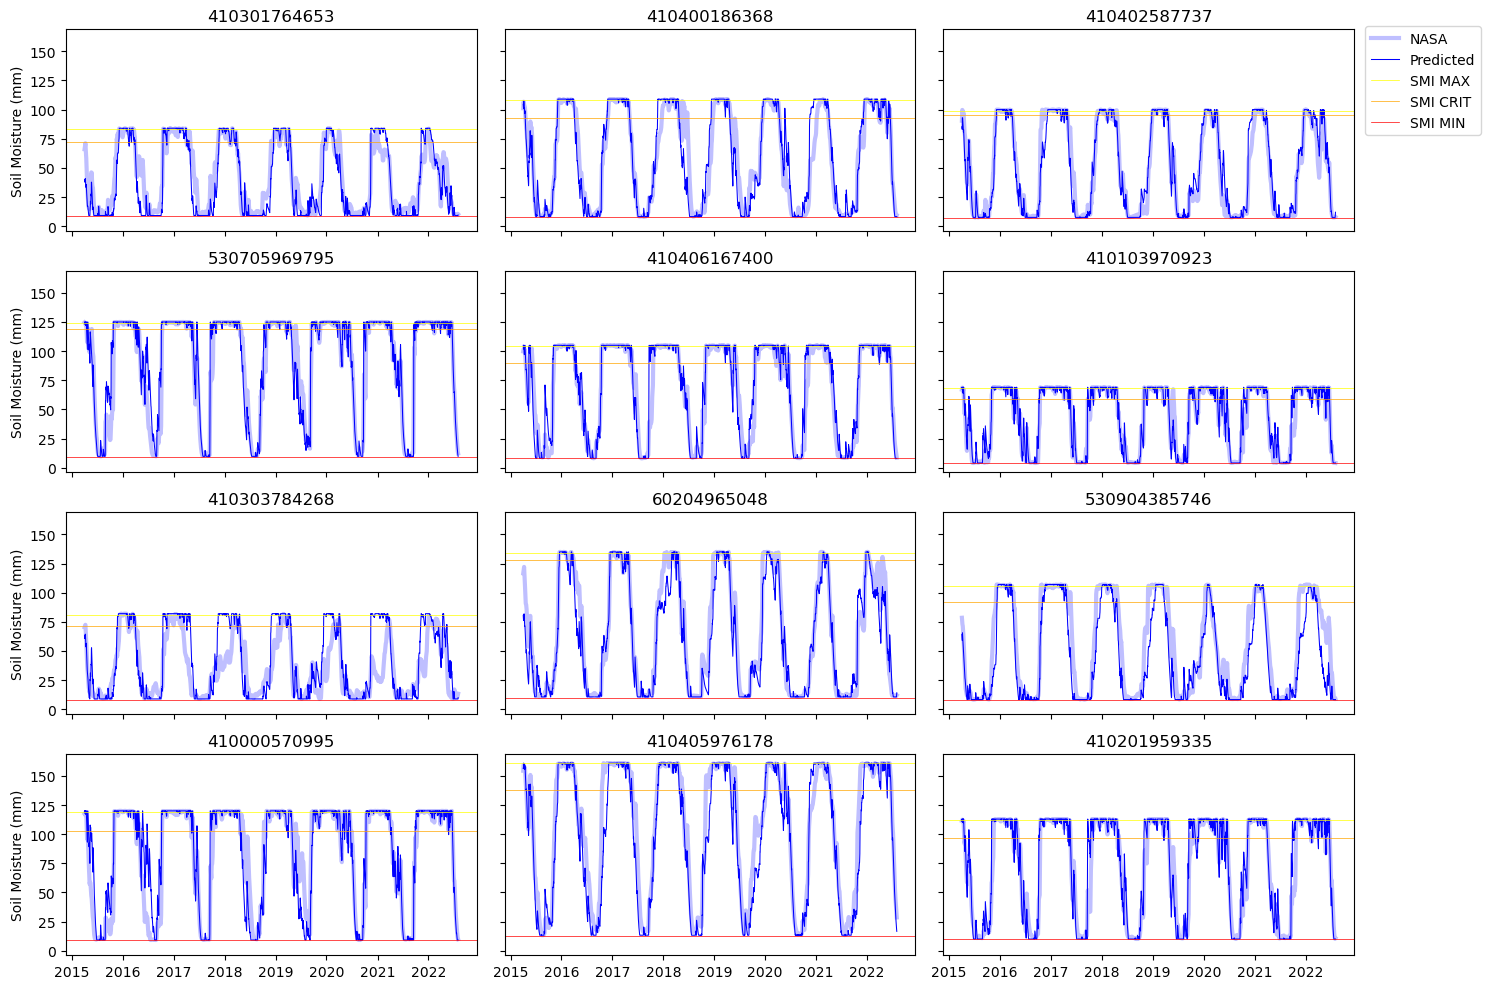

In [9]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
vis_plots = np.random.choice(plots.index, 16)
for i in range(12):
    to_plot = vis_plots[i]
    res = fit_3param(to_plot, get_data=True, get_params=True)
    while "SMI_MIN" not in res:
        new_plot = np.random.choice(plots.index, 1)[0]
        res = fit_3param(new_plot, get_data=True, get_params=True)
    dates = res["DATE"].to_timestamp()
    axs.ravel()[i].plot(dates, res["OBS"], color="blue", lw=3.0, alpha=0.25, label="NASA")
    axs.ravel()[i].plot(dates, res["PRED"], color="blue", lw=0.75, label="Predicted")
    axs.ravel()[i].axhline(res["SMI_MAX"], lw=0.5, color="yellow", label="SMI MAX")
    axs.ravel()[i].axhline(res["SMI_CRIT"], lw=0.5, color="orange", label="SMI CRIT")
    axs.ravel()[i].axhline(res["SMI_MIN"], lw=0.5, color="red", label="SMI MIN")
    # axs.ravel()[i].set_xlim(pd.Timestamp("2016-01-01"), pd.Timestamp("2021-12-31"))
    axs.ravel()[i].set_title(to_plot)
for ax in axs[:, 0]:
    ax.set_ylabel("Soil Moisture (mm)")
axs[0, -1].legend(bbox_to_anchor=(1.01, 1.05))
plt.tight_layout()
plt.savefig("../../reports/figures/example_leaky_bucket.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
# OVERWRITE = True
# OUTFILE = "../../data/interim/smi_coefs.csv"

# if OVERWRITE or not os.path.exists(OUTFILE):
#     results = pd.DataFrame(
#         index=pd.Series(plots.index, name="PLOT_ID", dtype=int),
#         columns=["SMI_MIN", "SMI_CRIT", "SMI_MAX"],
#         dtype="Int64"
#     )
# else:
#     results = pd.read_csv(OUTFILE).set_index("PLOT_ID").astype("Int64")
#     results.index = results.index.astype(int)

# # to_run = results.loc[results.SMI_CRIT.isna()].index.values
# to_run = plots.index.values[2:]

# to_run = plots.index
# num_jobs = len(to_run)
# results = []
# with tqdm(total=num_jobs) as pbar:   
#     with ProcessPoolExecutor(6) as executor:
#         jobs = [executor.submit(fit_3param, idx, get_params=True) for idx in to_run]
#         for job in as_completed(jobs):
#             results.append(job.result())
#             # if "SMI_MIN" in result:
#             #     idx = result.pop("PLOT_ID")
#             #     results.loc[idx] = result
#             # else:
#             #     pass
#             pbar.update()

In [11]:
results = []
with tqdm(total=len(plots)) as pbar:
    for p in plots.index:
        results.append(fit_3param(p))
        pbar.update()

  0%|          | 0/12156 [00:00<?, ?it/s]

In [18]:
result_df = (
    pd.DataFrame(results)
    .astype("Int64")
    .set_index("PLOT_ID")
)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SMI_MIN   12027 non-null  Int64
 1   SMI_CRIT  12027 non-null  Int64
 2   SMI_MAX   12027 non-null  Int64
dtypes: Int64(3)
memory usage: 427.4 KB


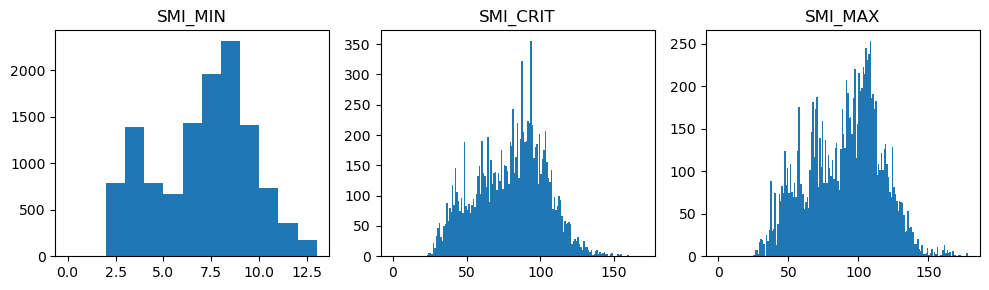

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for i, var in enumerate(["SMI_MIN", "SMI_CRIT", "SMI_MAX"]):
    axs[i].hist(result_df[var].dropna(), bins=np.arange(0, result_df[var].max()))
    axs[i].set_title(var)

plt.tight_layout()
plt.show()

In [20]:
SOIL_TYPES = "../../data/interim/soil_types.csv"
soil_types = pd.read_csv(SOIL_TYPES).set_index("PLOT_ID")
soil_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   b0      12156 non-null  int64
 1   b10     12156 non-null  int64
 2   b30     12156 non-null  int64
 3   b60     12156 non-null  int64
 4   b100    12156 non-null  int64
 5   b200    12156 non-null  int64
dtypes: int64(6)
memory usage: 664.8 KB


In [28]:
smi_coefs = soil_types.merge(result_df,
    left_index=True, right_index=True, how="left"
)
for col in ["SMI_MIN", "SMI_CRIT", "SMI_MAX"]:
    smi_coefs[col] = smi_coefs.groupby("b10")[col].transform(
        lambda x: x.fillna(int(x.mean()))
    )
smi_coefs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   b0        12156 non-null  int64
 1   b10       12156 non-null  int64
 2   b30       12156 non-null  int64
 3   b60       12156 non-null  int64
 4   b100      12156 non-null  int64
 5   b200      12156 non-null  int64
 6   SMI_MIN   12156 non-null  Int64
 7   SMI_CRIT  12156 non-null  Int64
 8   SMI_MAX   12156 non-null  Int64
dtypes: Int64(3), int64(6)
memory usage: 1.2 MB


In [29]:
OUTFILE = os.path.join(DATA_DIR, "interim", "smi_coefs.csv")
smi_coefs.to_csv(OUTFILE, index=True, header=True)

In [25]:
ALL_DATA = os.path.join(DATA_DIR, "interim", "leaky_bucket", "daily_leaky_bucket_all_plots.parquet")
all_data = pd.read_parquet(
    ALL_DATA, 
    columns=["PLOT_ID", "DATE", "PPT", "EREF_HARGREAVES"], 
)
all_data["DATE"] = pd.to_datetime(all_data.DATE).dt.to_period("D")
all_data.set_index(["PLOT_ID", "DATE"], inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98791046 entries, (410400199958, Period('2000-05-22', 'D')) to (60510975453, Period('2022-12-31', 'D'))
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   PPT              float64
 1   EREF_HARGREAVES  float64
dtypes: float64(2)
memory usage: 1.8 GB


In [49]:
all_data["SMI"] = np.nan

with tqdm(total=len(plots)) as pbar:
    for plot in plots.index:
        params = smi_coefs.loc[plot, ["SMI_MIN", "SMI_CRIT", "SMI_MAX"]].astype(float).values.reshape(-1,1)
        ppt = all_data.loc[plot, ["PPT"]]
        evap = all_data.loc[plot, ["EREF_HARGREAVES"]]

        smi = scan_leaky((ppt.values, evap.values), *params)[:,0]
        all_data.loc[plot, "SMI"] = smi
        pbar.update()

  0%|          | 0/12156 [00:00<?, ?it/s]

In [69]:
monthly_data = (
    all_data.reset_index(level=0)
    .groupby(by="PLOT_ID")
    .resample("M")
    .agg({"SMI": "mean", "PPT": "sum", "EREF_HARGREAVES": "sum"})
    .rename_axis(["PLOT_ID", "PERIOD"])
)
monthly_data.head()

SMI         PPT  EREF_HARGREAVES
PLOT_ID     PERIOD                                         
60101550679 1996-06  47.853961   14.882785       131.472333
            1996-07   8.531496    8.660372       194.956914
            1996-08   7.000000    0.000000       170.215512
            1996-09  35.892599   79.033758       110.162541
            1996-10  64.092152  247.356679        63.493232

In [66]:
ALL_SMAP = glob.glob(os.path.join(DATA_DIR, "raw", "nasa_smap", "*.parquet"))
smap = pd.concat([pd.read_parquet(f) for f in ALL_SMAP])
smap["DATE"] = pd.to_datetime(smap.DATE).dt.to_period("D")
smap["WHC"] = smap["SM_MM"] / smap["SMP"]
smap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10747328 entries, 0 to 893
Data columns (total 7 columns):
 #   Column   Dtype    
---  ------   -----    
 0   PLOT_ID  int64    
 1   DATE     period[D]
 2   SMP      float64  
 3   SSM      float64  
 4   SUSM     float64  
 5   SM_MM    float64  
 6   WHC      float64  
dtypes: float64(5), int64(1), period[D](1)
memory usage: 656.0 MB


In [70]:
whc = smap.groupby(by=["PLOT_ID"])["WHC"].mean()
whc

PLOT_ID
60101550679     103.0
60101551969     103.0
60101552953     109.0
60101553315     103.0
60101553519     103.0
                ...  
530906599117     33.0
530907152174    162.0
530907170686    164.0
530907182459    162.0
530907572668    156.0
Name: WHC, Length: 12027, dtype: float64

In [72]:
monthly_data["SMP"] = monthly_data["SMI"] / whc

In [73]:
monthly_data.to_csv(
    os.path.join(DATA_DIR, "interim", "monthly_soil_moisture_for_plots.csv"),
    index=True, 
    header=True,
)

In [74]:
monthly_data.reset_index().to_parquet(
    os.path.join(DATA_DIR, "interim", "monthly_soil_moisture_for_plots.parquet"),
    index=False
)